In [1]:
# I've selected Startups growth data dataset for this task

from constants.base import KaggleDatasetPaths
from auxiliary.ds.data_loader import DataLoader

dataframe = DataLoader.from_kaggle_path(KaggleDatasetPaths.STARTUPS_GROWTH).data
dataframe.head()

/home/err/Python/data-science/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataLoader(/home/err/.cache/kagglehub/datasets/adilshamim8/startup-growth-and-investment-data/versions/1/startup_growth_investment_data.csv): reading data.


,Startup Name,Industry,Funding Rounds,Investment Amount (USD),Valuation (USD),Number of Investors,Country,Year Founded,Growth Rate (%)
0,Startup_1,Blockchain,8,1.335166e+09,6.621448e+09,50,Germany,2012,77.10
1,Startup_2,SaaS,2,2.781498e+09,8.363214e+09,36,UK,2006,105.52
2,Startup_3,EdTech,10,3.309032e+09,1.548270e+10,39,Singapore,2016,190.47
3,Startup_4,Fintech,5,4.050196e+09,1.268253e+10,44,France,2021,9.44
4,Startup_5,EdTech,9,1.645080e+09,6.887966e+09,48,India,2011,192.00


In [2]:
# Creating database (if it does not exist already)

from auxiliary.db.base import DBConnection
from homeworks.hw3.config import DB_NAME

with DBConnection.from_secrets() as conn:
    cursor = conn.cursor()
    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {DB_NAME}")
    cursor.execute("SHOW DATABASES")
    act_db_names = tuple(db_name for db_name, *_ in cursor.fetchall())
    assert DB_NAME in act_db_names, 'Unexpected names of databases after creating new one: {act_db_names}'
    print('Seems to have worked fine')

Seems to have worked fine


In [3]:
# Need to understand what field types are needed for new table. Introspection of dataset columns:

from homeworks.hw3.config import DatasetFields
from auxiliary.db.base import MAP_FIELD_TYPES

for column in dataframe.columns:
    print(f"Column name: {column}, type: {dataframe[column].dtype}")

print("The following dataset-DB field types mapping will fit:")
for key, value in MAP_FIELD_TYPES.items():
    print(f"{key} => {value}")

# Seems that "Startup Name" is OK to be used as primary key in the table.
column = DatasetFields.NAME
print('Duplicates for "{column}" column:')
print(dataframe.duplicated((column.value,)).value_counts())

Column name: Startup Name, type: object
Column name: Industry, type: object
Column name: Funding Rounds, type: int64
Column name: Investment Amount (USD), type: float64
Column name: Valuation (USD), type: float64
Column name: Number of Investors, type: int64
Column name: Country, type: object
Column name: Year Founded, type: int64
Column name: Growth Rate (%), type: float64
The following dataset-DB field types mapping will fit:
object => VARCHAR(255)
int64 => INT
float64 => FLOAT(24)
Duplicates for "{column}" column:
False    5000
Name: count, dtype: int64


In [4]:
# Code for "CREATE TABLE" query:

from homeworks.hw3.config import TABLE_NAME
from auxiliary.db.base import get_column_db_repr

fields_desc = tuple(
    get_column_db_repr(column, dataframe[column].dtype, is_primary=column == DatasetFields.NAME.value)
    for column in dataframe.columns
)
cmd_create_table = f"CREATE TABLE IF NOT EXISTS {TABLE_NAME} ({', '.join(fields_desc)})"
print(f"Command for creeating table: {cmd_create_table}")

with DBConnection.from_secrets(database=DB_NAME) as conn:  # since db is created, we can pass its name to constructor
    cursor = conn.cursor()
    cursor.execute(cmd_create_table)
    cursor.execute("SHOW TABLES")
    act_table_names = tuple(table_name for table_name, *_ in cursor.fetchall())
    assert TABLE_NAME in act_table_names, 'Unexpected names of tables after creating new one: {act_table_names}'
    cursor.execute(f"DESCRIBE {TABLE_NAME}")
    print(f'Description of "{TABLE_NAME}" table:')
    for el in cursor.fetchall():
        print(el)

Command for creeating table: CREATE TABLE IF NOT EXISTS startups_data (startup_name VARCHAR(255) PRIMARY KEY, industry VARCHAR(255), funding_rounds INT, investment_amount_usd FLOAT(24), valuation_usd FLOAT(24), number_of_investors INT, country VARCHAR(255), year_founded INT, growth_rate FLOAT(24))
Description of "startups_data" table:
('startup_name', 'varchar(255)', 'NO', 'PRI', None, '')
('industry', 'varchar(255)', 'YES', '', None, '')
('funding_rounds', 'int(11)', 'YES', '', None, '')
('investment_amount_usd', 'float', 'YES', '', None, '')
('valuation_usd', 'float', 'YES', '', None, '')
('number_of_investors', 'int(11)', 'YES', '', None, '')
('country', 'varchar(255)', 'YES', '', None, '')
('year_founded', 'int(11)', 'YES', '', None, '')
('growth_rate', 'float', 'YES', '', None, '')


In [5]:
# Code for importing data from dataframe into table

import numpy as np
from auxiliary.db.base import get_insert_row_single

multiple_rows_data = ", ".join((get_insert_row_single(entry) for entry in dataframe.values))
cmd_insert_data = f"INSERT INTO {TABLE_NAME} VALUES {multiple_rows_data};"
cmd_get_count = f"SELECT COUNT(*) FROM {TABLE_NAME}"
with DBConnection.from_secrets(database=DB_NAME) as conn:
    cursor = conn.cursor()
    cursor.execute(cmd_insert_data)
    conn.commit()
    cursor.execute(cmd_get_count)
    (rows_count, *_), *_ = cursor.fetchall()
    print(f"# of rows in table after inserting: {rows_count}")

# of rows in table after inserting: 5000


In [6]:
# Code for selecting entries from table with filtering conditions

# get all industries of startups
query_0 = f'SELECT industry FROM {TABLE_NAME} GROUP BY industry'
# get names of 10 newest startups in Biotech
query_1 = f'SELECT startup_name FROM {TABLE_NAME} WHERE industry="biotech" ORDER BY year_founded DESC LIMIT 10'
# get 10 largest valuation_usd values
query_2 = f'SELECT valuation_usd FROM {TABLE_NAME} ORDER BY valuation_usd DESC LIMIT 10'
# get countries which have at least 500 startups
query_3 = f'SELECT country FROM {TABLE_NAME} GROUP BY country HAVING COUNT(*) > 500'

with DBConnection.from_secrets(database=DB_NAME) as conn:
    cursor = conn.cursor()
    for query in (query_0, query_1, query_2, query_3):
        cursor.execute(query)
        print(cursor.fetchall())

[('AI',), ('Biotech',), ('Blockchain',), ('E-commerce',), ('EdTech',), ('Fintech',), ('HealthTech',), ('SaaS',)]
[('Startup_722',), ('Startup_762',), ('Startup_912',), ('Startup_1303',), ('Startup_1820',), ('Startup_2021',), ('Startup_2069',), ('Startup_2133',), ('Startup_2475',), ('Startup_2523',)]
[(24709100000.0,), (24289200000.0,), (24263700000.0,), (24227300000.0,), (24142300000.0,), (23990200000.0,), (23960600000.0,), (23938000000.0,), (23860500000.0,), (23772800000.0,)]
[('Australia',), ('Brazil',), ('Singapore',), ('UK',), ('USA',)]


In [7]:
# Code for selecting entries from table with aggregation

# get 20 countries with biggest numbers of startups
query_0 = f'SELECT country, COUNT(*) FROM {TABLE_NAME} GROUP BY country ORDER BY COUNT(*) DESC LIMIT 20'
# get total investment in AI startups by years
query_1 = f'SELECT year_founded, SUM(investment_amount_usd) FROM {TABLE_NAME} WHERE industry="AI" GROUP BY year_founded'
# get 5 biggest valuation_usd values averaged over industries
query_2 = f'SELECT industry, AVG(valuation_usd) FROM {TABLE_NAME} GROUP BY industry ORDER BY AVG(valuation_usd) DESC LIMIT 5'
# get average startup growth rate for specific industries
query_3 = f'SELECT industry, AVG(growth_rate) FROM {TABLE_NAME} GROUP BY industry ORDER BY AVG(growth_rate) DESC'

with DBConnection.from_secrets(database=DB_NAME) as conn:
    cursor = conn.cursor()
    for query in (query_0, query_1, query_2, query_3):
        cursor.execute(query)
        print(cursor.fetchall())

[('Australia', 548), ('Brazil', 520), ('Singapore', 513), ('UK', 510), ('USA', 504), ('China', 497), ('Germany', 495), ('France', 489), ('India', 483), ('Canada', 441)]
[(2000, 56344027648.0), (2001, 72388488644.0), (2002, 52628751145.5), (2003, 70093272112.0), (2004, 42291258432.0), (2005, 32647623760.0), (2006, 66171544352.0), (2007, 73491801920.0), (2008, 58169462723.0), (2009, 69632545260.0), (2010, 60291694144.0), (2011, 76293080592.0), (2012, 86660516000.0), (2013, 110324308512.0), (2014, 51541047488.0), (2015, 67600919702.0), (2016, 76621951616.0), (2017, 67835807776.0), (2018, 51038785664.0), (2019, 56227715088.0), (2020, 46432023024.0), (2021, 45890391428.0), (2022, 52341613008.0), (2023, 34419167576.0)]
[('AI', 8212620520.787375), ('E-commerce', 8167838372.827805), ('Fintech', 8117729144.878049), ('Biotech', 8064938507.848185), ('Blockchain', 7946256306.176282)]
[('EdTech', 105.20069296603943), ('Fintech', 105.16367480657934), ('Blockchain', 103.32282043955264), ('SaaS', 103.

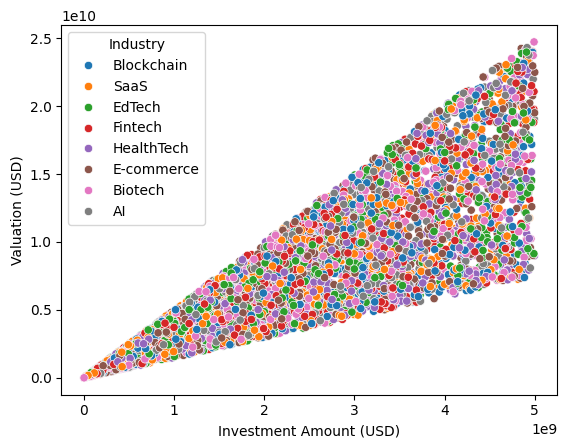

In [8]:
# Bulding scatter plots of investment_amount vs valuation_usd for different industries

from auxiliary.ds import get_scatter_plot, get_pair_plot
from homeworks.hw3.config import DatasetFields as Fields

get_scatter_plot(dataframe, x=Fields.INVESTMENT.value, y=Fields.VALUATION.value, hue=Fields.INDUSTRY.value)

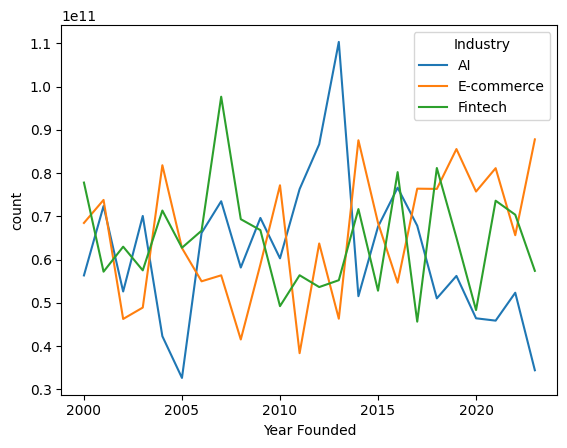

In [9]:
# Building linear plots of investment_amount for startups founded in specific year

from auxiliary.ds import get_linear_plot
import pandas as pd

query = f'SELECT year_founded, industry, SUM(investment_amount_usd) FROM {TABLE_NAME} WHERE industry IN ("AI", "E-Commerce", "Fintech") GROUP BY year_founded, industry'
with DBConnection.from_secrets(database=DB_NAME) as conn:
    cursor = conn.cursor()
    cursor.execute(query)
    years, industries, counts = zip(*cursor.fetchall())
    df_selected = pd.DataFrame({Fields.YEAR_FOUNDED.value: years, Fields.INDUSTRY.value: industries, 'count': counts})
get_linear_plot(df_selected, x=Fields.YEAR_FOUNDED.value, y='count', hue=Fields.INDUSTRY.value)